In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse, spatial
import pandas as pd

%matplotlib inline

from plot_help import plot_confusion_matrix , make_svd_hist_plot, make_svd_heatmap_plot

In [6]:
transcript = pd.read_csv("data/full_transcript.csv", index_col=0)
transcript['offer_id'] = transcript['offer_id'].astype(int)
transcript.head(10)

,person,offer_id,offer received,offer viewed,offer completed,transaction,reward,amount,difficulty,email,mobile,social,web,bogo,discount,informational
0,0,4,1,1,1,3,3.0,7.54,7,1,1,1,1,0,1,0
1,0,7,2,2,1,2,2.0,2.63,10,2,2,2,2,0,1,0
2,0,8,1,1,0,0,0.0,0.00,10,1,1,0,1,0,1,0
3,0,9,1,1,0,1,0.0,0.35,20,1,0,0,1,0,1,0
4,1,0,1,0,0,0,0.0,0.00,0,1,1,0,1,0,0,1
5,1,2,1,0,1,0,5.0,0.00,5,1,1,0,1,1,0,0
6,2,1,1,1,0,0,0.0,0.00,0,1,1,1,0,0,0,1
7,2,2,1,1,0,0,0.0,0.00,5,1,1,0,1,1,0,0
8,3,1,1,1,0,2,0.0,49.39,0,1,1,1,0,0,0,1
9,3,2,1,1,1,1,5.0,19.89,5,1,1,0,1,1,0,0


In [7]:
user_df = pd.read_csv("data/user_df_median.csv", index_col=1)
user_df = user_df.drop(columns=['Unnamed: 0'])

user_df.head()

,offer received,offer viewed,offer completed,transaction,reward_infl,amount_infl,email,mobile,social,web,...,avg_difficulty,time_to_open,time_to_complete,total_amount,amount_pct,age,gender,income,seen_ratio,completed_ratio
person,,,,,,,,,,,,,,,,,,,,,
0.0,5.0,5.0,2.0,6.0,5.0,10.52,5.0,4.0,3.0,5.0,...,12.0,0.083929,0.285714,20.40,0.515686,55.0,2.0,64000.0,1.0,0.40
1.0,2.0,0.0,1.0,0.0,5.0,0.00,2.0,2.0,0.0,2.0,...,2.0,1.000000,1.000000,77.01,0.000000,55.0,0.0,112000.0,0.0,0.50
2.0,2.0,2.0,0.0,0.0,0.0,0.00,2.0,2.0,1.0,1.0,...,2.0,0.000000,1.000000,14.30,0.000000,55.0,2.0,64000.0,1.0,0.00
3.0,4.0,4.0,3.0,3.0,20.0,69.28,4.0,4.0,3.0,2.0,...,5.0,0.234127,0.785714,159.27,0.434985,75.0,0.0,100000.0,1.0,0.75
4.0,5.0,3.0,0.0,1.0,0.0,1.09,5.0,2.0,1.0,4.0,...,7.0,0.012500,1.000000,4.65,0.234409,55.0,2.0,64000.0,0.6,0.00


In [8]:
user_df_scaled = pd.read_csv("data/user_scaled.csv")


In [9]:
user_df.columns


Index(['offer received', 'offer viewed', 'offer completed', 'transaction',
       'reward_infl', 'amount_infl', 'email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'avg_difficulty', 'time_to_open',
       'time_to_complete', 'total_amount', 'amount_pct', 'age', 'gender',
       'income', 'seen_ratio', 'completed_ratio'],
      dtype='object')

In [10]:
transcript_offerid_sum = transcript.groupby(by='offer_id', as_index=True).sum()
transcript_offerid_sum = transcript_offerid_sum[['offer received','offer viewed', 'amount']]
transcript_offerid_sum['view_ratio'] = transcript_offerid_sum['offer viewed'] / transcript_offerid_sum['offer received']
transcript_offerid_sum['amount_per_view'] = transcript_offerid_sum['amount'] / transcript_offerid_sum['offer viewed']

transcript_offerid_sum

,offer received,offer viewed,amount,view_ratio,amount_per_view
offer_id,,,,,
0,7617,4144,39591.26,0.544046,9.553875
1,7618,6687,54291.40,0.877789,8.118947
2,7677,4171,26874.43,0.543311,6.443162
3,7571,7264,55226.14,0.959451,7.602718
4,7646,7337,54806.01,0.959587,7.469812
5,7658,6716,58728.75,0.876991,8.744602
6,7593,7298,58246.78,0.961148,7.981198
7,7597,7327,63546.65,0.964460,8.672943
8,7632,4118,31817.55,0.539570,7.726457


In [11]:
def most_viewed_offer (transcript_offerid_sum, top_k=5):
    """
    Returns the top k most popular offer ids
    Inputs:
    -transcript_offerid_sum(pandas): dataframe with offer id as index and statistics as columns
    -topk(int): number of predictions
    """
    
    #get an upper bound estiamte
    top_k_max = transcript_offerid_sum.shape[0]
    
    #replace upper bound
    if top_k > top_k_max:
        print("can't return more items than unique offer id")
        print("function will return  the maximum possible: {}".format(top_k_max))
        top_k = top_k_max
    
    #sort first by view ratio, then by money made per view
    sorted_transcript = transcript_offerid_sum.sort_values(by=['view_ratio', 'amount_per_view'], ascending=False)
    
    top_offers = sorted_transcript.index.tolist()[:top_k]
    
    return top_offers

In [12]:
#Sample output
most_viewed_offer(transcript_offerid_sum, top_k=3)

[7, 6, 4]

In [13]:
#Sample edge case
most_viewed_offer(transcript_offerid_sum, top_k=300)

can't return more items than unique offer id
function will return  the maximum possible: 10


[7, 6, 4, 3, 1, 5, 0, 2, 8, 9]

In [14]:
def most_profit_offer (transcript_offerid_sum, top_k=5):
    """
    Returns the top k most profitable offer ids
    Inputs:
    -transcript_offerid_sum(pandas): dataframe with offer id & view ratio
    -topk(int): number of predictions
    """
    
    top_k_max = transcript_offerid_sum.shape[0]
    
    if top_k > top_k_max:
        print("can't return more items than unique offer id")
        print("function will return  the maximum possible: {}".format(top_k_max))
        top_k = top_k_max
        
    sorted_transcript = transcript_offerid_sum.sort_values(by=['amount_per_view', 'view_ratio'], ascending=False)
    
    top_offers = sorted_transcript.index.tolist()[:top_k]
    
    
    return top_offers

In [15]:
#sample output
most_profit_offer (transcript_offerid_sum, top_k=3)

[9, 0, 5]

In [16]:
#edge case 
most_profit_offer (transcript_offerid_sum, top_k=3000)

can't return more items than unique offer id
function will return  the maximum possible: 10


[9, 0, 5, 7, 1, 6, 8, 3, 4, 2]

In [17]:
user_views = transcript[['person', 'offer_id', 'offer viewed']]
#shuffle the entries
user_views = user_views.sample(frac=1)

user_views.head()

,person,offer_id,offer viewed
61215,16439,6,1
52925,14200,4,1
18851,5067,2,0
11497,3101,0,0
47586,12761,6,1


In [18]:

# Create user-by-item matrix
user_by_item = user_views.groupby(['person', 'offer_id'])['offer viewed'].max().unstack()


#drop rows that are entirely nan
user_by_item = user_by_item.dropna(how='all')

user_by_item.head()

offer_id,0,1,2,3,4,5,6,7,8,9
person,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1.0,1.0
1,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
4,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [19]:

def get_offers_seen(user_by_item, user):
    """
    Get the offers seen by a user, sort by most viewed first
    Inputs:
    - user_by_user(pandas): user item matrix with user as index and offer id as column
    - user(int): the user id
    
    Output:
    - offers_seen(list): an array of offers seen
    """
    
    #get seen offers
    user_offers_seen = user_by_item.loc[user][user_by_item.loc[user].isna()==False]
    
    #sort by descending order
    user_offers_seen = user_offers_seen.sort_values(ascending=False)
    
    #get values
    user_offers_seen = user_offers_seen.index.values.tolist()
    
    return user_offers_seen

In [20]:
def create_user_offer_dict(user_by_item):
    """
    Input:
    - user_by_user(pandas): user item matrix with user as index and offer id as column
    Output:
    offers_seen(dict): user ID as key and offers viewed as values
    """
    
    #dict key is user and values are offers seen
    offers_seen = dict()
    
    #for each user get the offers seen
    for user in user_by_item.index:
        offers_seen[user] = get_offers_seen(user_by_item, user)
        
    return offers_seen

In [21]:
#get a dict of seen offers
offers_seen_dict = create_user_offer_dict(user_by_item)

In [22]:
#get sample output
offers_seen_dict[0]

[7, 9, 8, 4]

In [23]:
def compute_similarity_euclid(user1_id, user2_id,user_df=user_df):
    """
    Compute the euclidian distance between two users
    Inputs:
    - user1(int): fist user id
    - user2(int): second user id
    - user_df(pandas): features about users
    Output:
    - norm(numpy.float64): norm between two users
    """
    #get user rows
    user1 = user_df.loc[user1_id]
    user2 = user_df.loc[user2_id]
    
    #ge the difference
    diff = user1 - user2
    
    #drop nans
    diff= diff.dropna()
    
    #calculate the norm
    norm = np.linalg.norm(diff)
    
    return norm

In [24]:
#sample output
compute_similarity_euclid(5, 32)

84.93585510237546

In [25]:
def compute_similarity_corr(user1_id, user2_id, user_df=user_df, method='pearson'):
    """
    Compute the pearson correlation  between two users
    Inputs:
    - user1(int): fist user id
    - user2(int): second user id
    - user_df(pandas): features about users
    Output:
    - corr(numpy.float64): correlation
    """
    
    #make dataframe from user ids
    df_corr = user_df.loc[[user1_id, user2_id]]
    
    #get correlation and select term off the diagonal
    corr = df_corr.transpose().corr(method).iloc[0,1]
    
    return corr

In [26]:
compute_similarity_corr(42, 1)

0.999998235549934

In [27]:
compute_similarity_corr(42, 1, method='kendall')


0.45560568900151466

In [28]:
def compute_similarity_cosine(user1_id, user2_id,user_df=user_df):
    """
    Compute the cosine distance  between two users
    Inputs:
    - user1(int): fist user id
    - user2(int): second user id
    - user_df(pandas): user feature dataframe
    Output:
    - cos_dist(numpy.float64): cosine distance
    """
    
    #get user rows
    user1 = user_df.loc[user1_id]
    user2 = user_df.loc[user2_id]
    
    cos_dist = 1 - spatial.distance.cosine(user1, user2)
    
    
    return cos_dist

In [29]:
#sample
compute_similarity_cosine(42, 77)

0.9999982548512846

In [30]:
def find_most_similar(user, user_df=user_df, method='pearson', corr='pearson'):
    """
    Find the most similar users to a given user id
    Inputs:
    - user(int): user idx
    - user_df(pandas): features about users
    - method(str): method to get similarity (pearson, euclid)
    Output:
    - most_sim_users(np.array): sorted list of most similar users
    """
    
    #store similarities here
    sim_list= []

    
    if method =='pearson':
        for idx in user_df.index:
            sim = compute_similarity_corr(user, idx, user_df, corr)
            sim_list.append(sim)
        #convert to numpy array
        sim_list= np.array(sim_list)
        
        #get ids sorted in DESCENDING order for PEARSON
        most_sim_users = sim_list.argsort()[::-1]
        #drop the first user
        most_sim_users = most_sim_users[1:]
        
    if method =='euclid':
        for idx in user_df.index:
            sim = compute_similarity_euclid(user, idx)
            sim_list.append(sim)
        #convert to numpy array
        sim_list= np.array(sim_list)
        
        #get ids sorted in ASCENDING order for EUCLIDIAN
        most_sim_users = sim_list.argsort()
        #drop the first user
        most_sim_users = most_sim_users[1:]
        
        
        if method =='cosine':
            for idx in user_df.index:
                sim = compute_similarity_cosine(user, idx)
                sim_list.append(sim)
            #convert to numpy array
            sim_list= np.array(sim_list)

            #get ids sorted in DESCENDING order for COSINE
            most_sim_users = sim_list.argsort()[::-1]
            #drop the first user
            most_sim_users = most_sim_users[1:]

        
    return most_sim_users

In [31]:
def make_collab_recomm(user, offers_seen_dict = offers_seen_dict,
                       top_k = 2, user_by_item = user_by_item,
                       user_df = user_df, method='pearson', verbose=True):
    
    """
    Make offer recommendations for a user
    Inputs:
    - user(int): user idx
    - offers_seen_dict(dict): user idx as key and offers seen as values
    - top_k(int): number of recommendations to make
    - user_by_item(pandas): user item dataframe with users as rows, offers as columns, and times seen as values
    - user_df(pandas): features about users
    - method(str): method to get similarity (pearson, euclid)
    Output:
    - offers_to_user(list): array of offers for user
    
    """
    
    #find the most similar users
    sim_to_user = find_most_similar(user, user_df, method)
    
    #get offers seen
    idx_seen = offers_seen_dict[user]
    
    if verbose:
        print("Similarity measured by {}".format(method))
        print("Original user {} already saw: \t {}".format(user, idx_seen))
    
    #get number of offers already seen
    idx_seen_len = len(idx_seen)
    
    #get number of offers available
    len_available = user_by_item.shape[1]
    
    if top_k > (len_available - idx_seen_len):
        print("Top k of {} is bigger than possible, will return only {} offers".format(top_k, (len_available - idx_seen_len)))
        top_k = (len_available - idx_seen_len)
        
    #empty set to store unique offer ids
    proposed_offers = np.array([])
        
    for idx in sim_to_user:
        idx_sim_offer = offers_seen_dict[idx]
        
        new_offers = (np.setdiff1d(idx_sim_offer,idx_seen))
        
        if verbose:
            print("Similar user {} saw: \t {}".format(idx, idx_sim_offer))
            print("Unseen offers by original user: \t {}".format(new_offers))
        
        proposed_offers = np.unique(np.concatenate([new_offers, proposed_offers], axis=0))
        print("We propose so far: {}".format(proposed_offers))
            
        
        if len(proposed_offers)>top_k:
            break
    
    proposed_offers = proposed_offers[0:top_k]
    
    if verbose:
        print("\nFor user {} we suggest offers : \t {}".format(user, proposed_offers))
    
    return proposed_offers

In [32]:

#get sample output with pearson
make_collab_recomm(5, top_k=3, verbose=True)


Similarity measured by pearson
Original user 5 already saw: 	 [8, 7, 2, 0]
Similar user 6534 saw: 	 [0, 8, 6, 3]
Unseen offers by original user: 	 [3 6]
We propose so far: [3. 6.]
Similar user 1307 saw: 	 [3, 7, 6, 2]
Unseen offers by original user: 	 [3 6]
We propose so far: [3. 6.]
Similar user 98 saw: 	 [5, 9, 1]
Unseen offers by original user: 	 [1 5 9]
We propose so far: [1. 3. 5. 6. 9.]

For user 5 we suggest offers : 	 [1. 3. 5.]


array([1., 3., 5.])

In [33]:
#sample output for euclidian distance
make_collab_recomm(5, top_k=3, method='euclid',verbose=True)

Similarity measured by euclid
Original user 5 already saw: 	 [8, 7, 2, 0]
Similar user 440 saw: 	 [6, 3, 2]
Unseen offers by original user: 	 [3 6]
We propose so far: [3. 6.]
Similar user 12411 saw: 	 [6, 1, 8]
Unseen offers by original user: 	 [1 6]
We propose so far: [1. 3. 6.]
Similar user 10854 saw: 	 [7, 6, 4, 2]
Unseen offers by original user: 	 [4 6]
We propose so far: [1. 3. 4. 6.]

For user 5 we suggest offers : 	 [1. 3. 4.]


array([1., 3., 4.])

In [34]:
#convert user item matrix to numpy
ratings_mat = np.array(user_by_item)

In [35]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100, print_every=25):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    - user_by_item(df): user item dataframe with users as rows, offers as columns, and times seen as values
    - latent_features: (int) the number of latent features used
    - learning_rate: (float) the learning rate 
    - iters: (int) the number of iterations
    
    OUTPUT:
    - user_mat(numpy.array): a user by latent feature matrix
    - item_mat(numpy.array) a latent feature by item matrix
    '''
    
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_items = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and item matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    item_mat = np.random.rand(latent_features, n_items)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-item pair
        for i in range(n_users):
            for j in range(n_items):
                
                # if the rating exists
                if ratings_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and item latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], item_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*item_mat[k, j])
                        item_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        if iteration % print_every ==0:
            print("%d \t\t %f" % (iteration, sse_accum / num_ratings))
        
    return user_mat, item_mat

In [36]:
def create_train_test(reviews, training_size, testing_size):
    '''    
    INPUT:
    - reviews(pandas df): dataframe to split into train and test
    - order_by(string): column name to sort by
    - training_size(int): number of rows in training set
    - testing_size(int): number of columns in the test set
    
    OUTPUT:
    - training_df(pandas df): dataframe of the training set
    - validation_df(pandas df): dataframe of the test set
    '''
    reviews_new = reviews.copy()
    training_df = reviews_new.head(training_size)
    validation_df = reviews_new.iloc[training_size:training_size+testing_size]
    
    return training_df, validation_df

In [37]:
#make train and valid sets from df below
user_views.head()

,person,offer_id,offer viewed
61215,16439,6,1
52925,14200,4,1
18851,5067,2,0
11497,3101,0,0
47586,12761,6,1


In [38]:
user_views.shape

(63288, 3)

In [39]:
train_df, val_df = create_train_test(user_views, 55000, 5000)

In [40]:
train_df.head()


,person,offer_id,offer viewed
61215,16439,6,1
52925,14200,4,1
18851,5067,2,0
11497,3101,0,0
47586,12761,6,1


In [41]:
val_df.head()


,person,offer_id,offer viewed
2399,648,8,1
1596,429,6,1
40812,10940,8,0
17391,4676,5,1
52835,14173,9,0


In [42]:
# Create user-by-item matrix 
train_user_item = train_df[['person', 'offer_id', 'offer viewed']]
train_data_df = train_user_item.groupby(['person', 'offer_id'])['offer viewed'].max().unstack()
train_data_np = np.array(train_data_df)

train_data_df.head()

offer_id,0,1,2,3,4,5,6,7,8,9
person,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1.0,1.0
1,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
4,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Fit FunkSVD with the specified hyper parameters to the training data
k = 25
lr = 0.005


user_mat, item_mat = FunkSVD(train_data_np, latent_features=k, learning_rate=lr, iters=150)

Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.216661
25 		 0.140184
50 		 0.123270
75 		 0.104310
100 		 0.079940
125 		 0.052530


In [44]:
def predict_rating(user_matrix, item_matrix, user_id, item_id, train_data_df = train_data_df):
    '''
    INPUT:
    - user_matrix(numpy.array): user by latent factor matrix
    - item_matrix(numpy.array): latent factor by item matrix
    - user_id(int): the user id
    - item(int): the item id according the  df
    - train_data_df(pandas):
    
    OUTPUT:
    - pred(int): the predicted rating for user_id-item_id according to FunkSVD
    '''
    # Use the training data to create a series of users and items that matches the ordering in training data
    user_ids_series = np.array(train_data_df.index)
    item_ids_series = np.array(train_data_df.columns)
    
    # User row and items Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    item_col = np.where(item_ids_series == item_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], item_matrix[:, item_col])
    
    #round because we are dealing with integers
    
    return pred

In [45]:
#sample output
predict_rating(user_mat, item_mat, 2, 2)

1.172310450118911

In [46]:
#more outputs
predict_rating(user_mat, item_mat, 2000, 9)


1.3360505830412008

In [47]:
def validation_comparison(val_df, user_mat=user_mat, item_mat=item_mat):
    '''
    INPUT:
    - val_df(pandas): the validation dataset created in the third cell above
    - user_mat(numpy.array): U matrix in FunkSVD
    - item_mat(numpy.array): V matrix in FunkSVD
        
    OUTPUT:
    - rmse(float) RMSE of how far off each value is from it's predicted value
    - perc_rated(float) percent of predictions out of all possible that could be rated
    - actual_v_pred(numpy.array) a 10 x 10 grid with counts for actual vs predicted values
    '''
        
    val_users = np.array(val_df['person'])
    val_items = np.array(val_df['offer_id'])
    val_ratings = np.array(val_df['offer viewed'])
    
    sse = 0
    num_rated = 0
    preds, acts = [], []
    actual_v_pred = np.zeros((10,10))
    for idx in range(len(val_users)):
        try:
            pred = predict_rating(user_mat, item_mat, val_users[idx], val_items[idx])
            sse += (val_ratings[idx] - pred)**2
            num_rated+=1
            preds.append(pred)
            acts.append(val_ratings[idx])
            actual_v_pred[11-int(val_ratings[idx]-1), int(round(pred)-1)]+=1
        
        except:
            continue
    
    rmse = np.sqrt(sse/num_rated)
    perc_rated = num_rated/len(val_users)
    return rmse, perc_rated, actual_v_pred, preds, acts

In [48]:
rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(val_df)


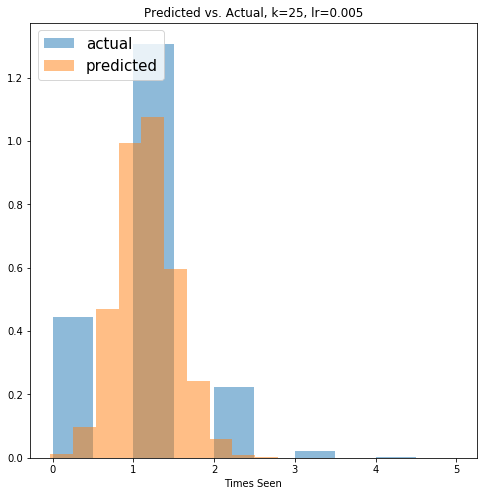

In [49]:
make_svd_hist_plot(k, lr, acts, preds)


Confusion matrix, without normalization
Confusion Matrix: 
[[   8  948  143    0    0    0]
 [  86 2528  612    2    0    0]
 [  26  417  108    1    0    0]
 [   2   49    2    0    0    0]
 [   0    2    1    0    0    0]
 [   0    1    0    0    0    0]]
Plotted confusion matrix


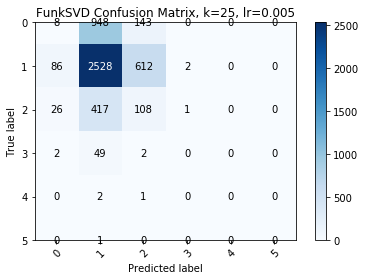

In [50]:
plot_confusion_matrix(acts, np.round(preds), title="FunkSVD Confusion Matrix, k={}, lr={}".format(k,lr),normalize=False)


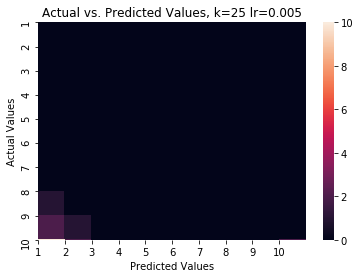

In [51]:
make_svd_heatmap_plot(k, lr, actual_v_pred)


Evaluation for k=25 and lr=0.005
Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.227941
25 		 0.139666
50 		 0.121801
75 		 0.100854
100 		 0.074009
125 		 0.045873
150 		 0.024735
175 		 0.012457
Confusion matrix, without normalization
Confusion Matrix: 
[[  18  856  225    0    0    0]
 [ 136 2362  727    3    0    0]
 [  19  405  128    0    0    0]
 [   4   37   12    0    0    0]
 [   0    3    0    0    0    0]
 [   0    0    1    0    0    0]]
Plotted confusion matrix


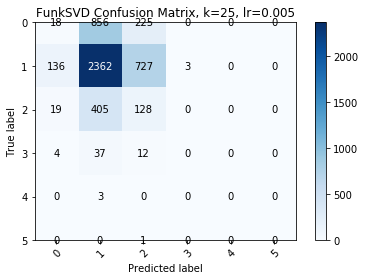

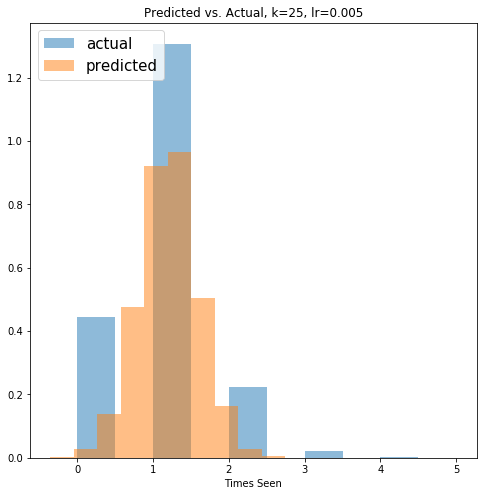

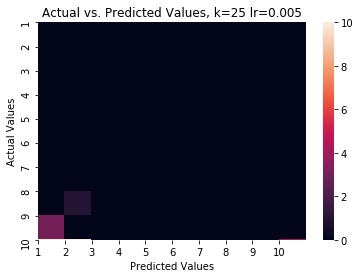

Evaluation for k=30 and lr=0.005
Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.236153
25 		 0.141428
50 		 0.123384
75 		 0.099445
100 		 0.068286
125 		 0.038760
150 		 0.019433
175 		 0.009382
Confusion matrix, without normalization
Confusion Matrix: 
[[  45  863  191    0    0    0]
 [ 164 2415  646    3    0    0]
 [  24  428   99    1    0    0]
 [   4   35   14    0    0    0]
 [   0    3    0    0    0    0]
 [   0    1    0    0    0    0]]
Plotted confusion matrix


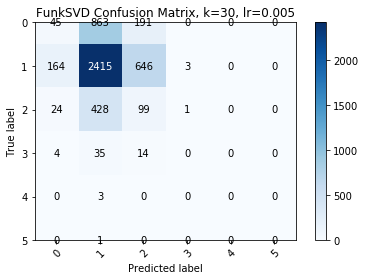

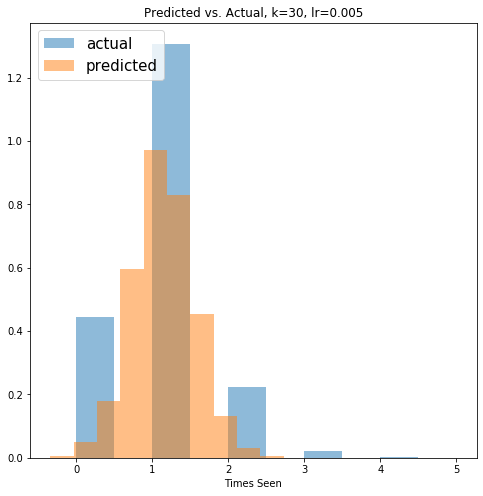

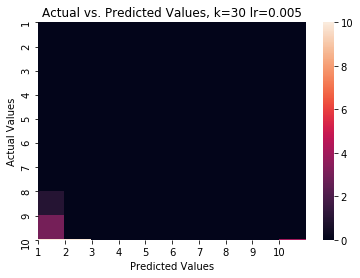

Evaluation for k=35 and lr=0.005
Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.251198
25 		 0.141976
50 		 0.124531
75 		 0.099184
100 		 0.065275
125 		 0.034444
150 		 0.015882
175 		 0.007106
Confusion matrix, without normalization
Confusion Matrix: 
[[  34  815  247    3    0    0]
 [ 141 2292  791    4    0    0]
 [  31  376  145    0    0    0]
 [   2   40   11    0    0    0]
 [   1    2    0    0    0    0]
 [   0    0    1    0    0    0]]
Plotted confusion matrix


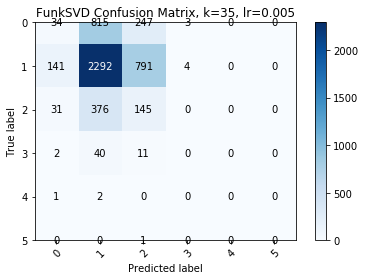

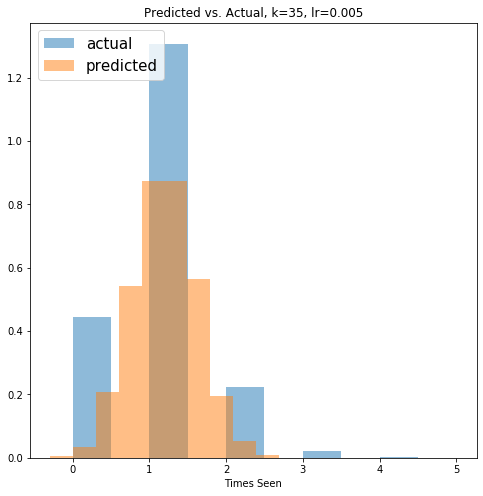

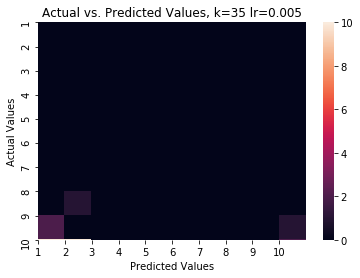

Evaluation for k=25 and lr=0.008
Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.209060
25 		 0.132066
50 		 0.097697
75 		 0.053134
100 		 0.020481
125 		 0.007145
150 		 0.002685
175 		 0.001154
Confusion matrix, without normalization
Confusion Matrix: 
[[  45  854  200    0    0    0]
 [ 157 2309  753    9    0    0]
 [  33  398  120    1    0    0]
 [   5   32   16    0    0    0]
 [   0    3    0    0    0    0]
 [   0    1    0    0    0    0]]
Plotted confusion matrix


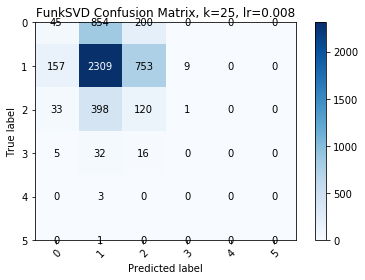

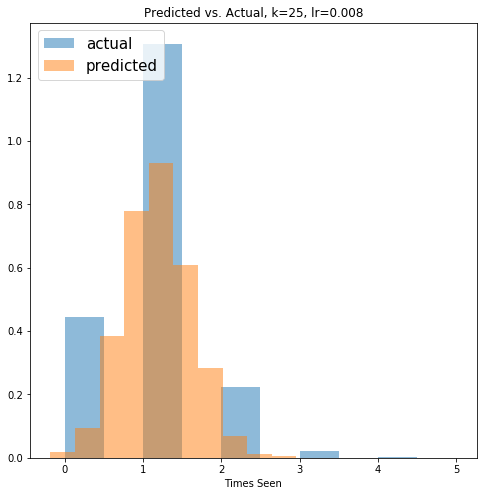

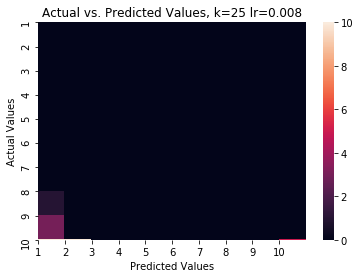

Evaluation for k=30 and lr=0.008
Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.213467
25 		 0.134284
50 		 0.094190
75 		 0.044118
100 		 0.015436
125 		 0.005297
150 		 0.002027
175 		 0.000905
Confusion matrix, without normalization
Confusion Matrix: 
[[  36  857  206    0    0    0]
 [ 194 2365  665    4    0    0]
 [  36  414  102    0    0    0]
 [   3   43    7    0    0    0]
 [   0    2    1    0    0    0]
 [   0    1    0    0    0    0]]
Plotted confusion matrix


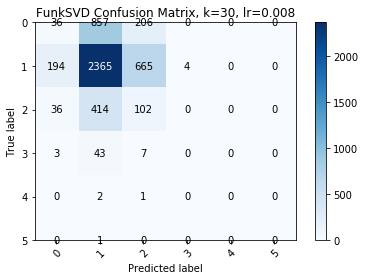

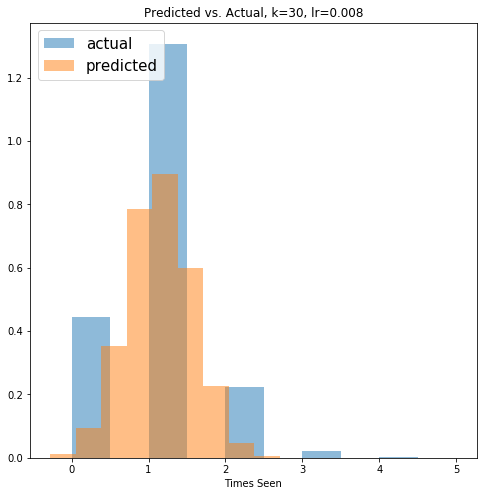

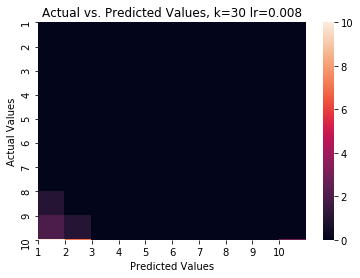

Evaluation for k=35 and lr=0.008
Optimizaiton Statistics
Iterations | Mean Squared Error 
0 		 0.235412
25 		 0.136883
50 		 0.094029
75 		 0.041080
100 		 0.013935
125 		 0.004969
150 		 0.002011
175 		 0.000938
Confusion matrix, without normalization
Confusion Matrix: 
[[  39  839  219    2    0    0]
 [ 139 2284  797    8    0    0]
 [  36  377  139    0    0    0]
 [   1   39   13    0    0    0]
 [   0    2    1    0    0    0]
 [   0    0    1    0    0    0]]
Plotted confusion matrix


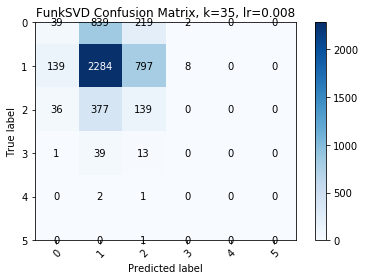

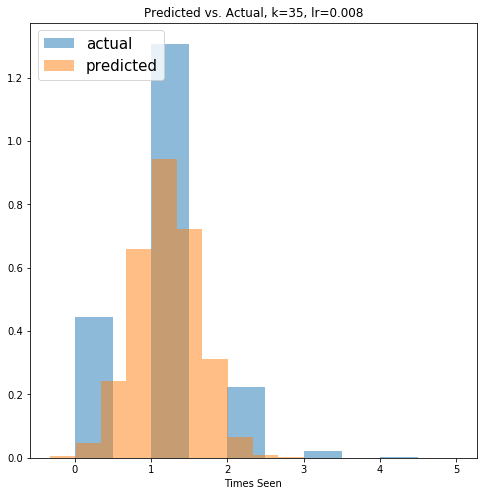

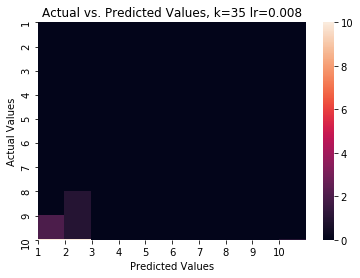



best_k = 	30
best_lr= 	0.005
best_rmse =  	0.7687


In [52]:
k_grid = [25, 30, 35]
lr_grid = [0.005, 0.008]

#placeholder value
best_k =0
best_lr=0
best_rmse = np.inf
best_perc_rated = None
best_user_mat= None
best_item_mat = None
best_actual_v_pred = None
best_preds = None
best_acts = None

for lr in lr_grid:
    for k in k_grid:
        print("Evaluation for k={} and lr={}".format(k, lr))
        
        user_mat_test, item_mat_test = FunkSVD(train_data_np, latent_features=k, learning_rate=lr, iters=200)
        rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(val_df, user_mat_test, item_mat_test)
        
        #record with plots
        title = 'FunkSVD Confusion Matrix, k={}, lr={}'.format(k, lr)
        save_path = "plots/svd_cm_"+"lr"+str(best_lr)+"_k"+str(best_k)+".png"
        plot_confusion_matrix(acts, np.round(preds), normalize=False, title=title, saveloc = save_path)  
        
        make_svd_hist_plot(k, lr, acts, preds)
        make_svd_heatmap_plot(k, lr, actual_v_pred)
              

        #update params if improved
        if rmse < best_rmse:
            #update score
            best_rmse = rmse
            #update params
            best_k = k
            best_lr=lr
            
            #store best results
            best_perc_rated = perc_rated
            best_user_mat= user_mat_test
            best_item_mat = item_mat_test
            best_actual_v_pred = actual_v_pred
            best_preds = preds
            best_acts = acts

print("\n")        
print("best_k = \t{}".format(best_k))
print("best_lr= \t{}".format(best_lr))
print("best_rmse =  \t{:.4f}".format(best_rmse))

In [53]:
#see how many users we could predit for
best_perc_rated

0.9872